In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F

from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
from keychest.keychestenv import keychest_obs3d_to_obs2d, keychest_obs2d_to_image
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
import cloudpickle as pickle
from causal_util.helpers import one_hot_encode
import gin

In [2]:
ckpt = '/home/sergei/ckpt1'

In [3]:
with open(ckpt, 'rb') as f:
    learner = pickle.load(f)

/home/sergei/miniconda3/envs/causal/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning
/home/sergei/miniconda3/envs/causal/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


Make environment KeyChest-v0 None {}


In [7]:
env = learner.env
h, w, c = env.engine._observation.shape

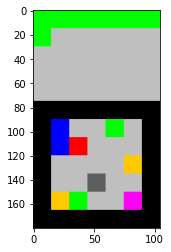

In [8]:
obs = env.reset()
obs = obs.reshape(h, w, c)
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs)))
plt.show()

In [9]:
learner.decoder(3)

3

In [10]:
learner.model

ModelModel(
  (model): FCNet(
    (activation): Tanh()
    (fc01): Linear(in_features=928, out_features=1000, bias=True)
    (fc02): Linear(in_features=1000, out_features=1000, bias=True)
    (fc03): Linear(in_features=1000, out_features=924, bias=True)
  )
)

In [37]:
from inspect import getsource

In [33]:
learner.collector.clear()

In [34]:
learner.collect_steps()

In [35]:
learner.collector.steps

10001

In [22]:
from sparse_causal_model_learner_rl.loss.losses import fit_loss

In [36]:
fit_loss(**learner._context).item()

0.0005435958155430853

In [12]:
#for _ in range(100):
#    learner._epoch()

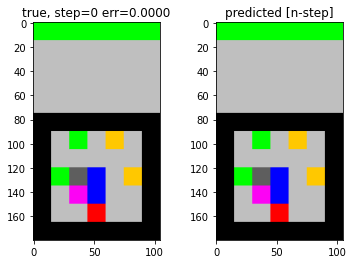

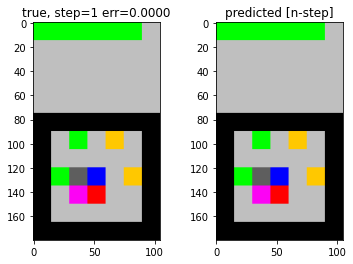

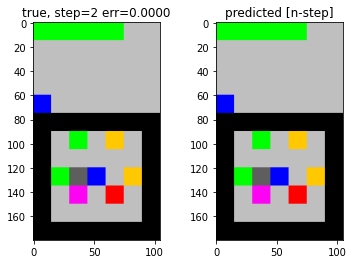

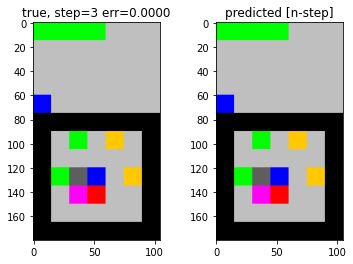

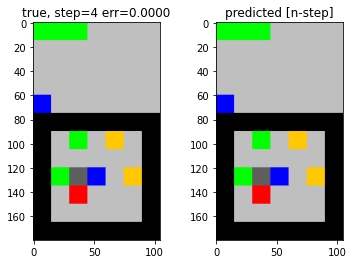

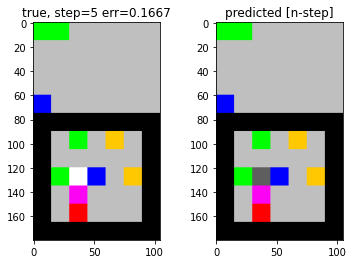

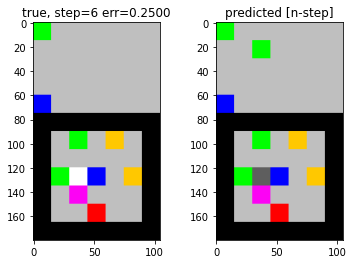

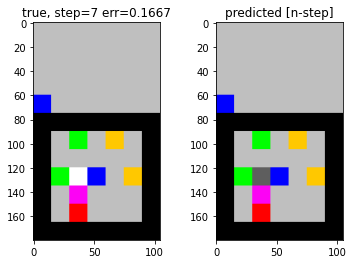

In [14]:
obs = env.reset()
obs_model = torch.tensor(obs).to(learner.device)
obs_models = []
errors = []

step = 0
while True:
    action = env.action_space.sample()
    act_one_hot = one_hot_encode(env.action_space.n, action)
    
    obs_model = learner.model(
#         obs_model.unsqueeze(0), # previous model observation
        torch.tensor(obs).to(learner.device).unsqueeze(0), # previous true observation
        torch.tensor(act_one_hot).to(learner.device).unsqueeze(0),
    )[0]
    
    obs_model_show = obs_model.cpu().detach().numpy().reshape(h, w, c)
    obs_models.append(obs_model_show)
    obs_model_show = obs_model_show > 0.5
    
    obs, rew, done, info = env.step(action)
    
    obs_show = obs.reshape(h, w, c)
    error = np.linalg.norm((obs_show - obs_model_show).flatten()) ** 2 / len(obs_show)
    errors.append(error)
    
    plt.subplot(1, 2, 1)
    plt.title("true, step=%d err=%.4f" % (step, error))
    plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs_show)))
    plt.subplot(1, 2, 2)
    plt.title("predicted [n-step]")
    plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs_model_show)))
    plt.show()
    
    step += 1
    if done: break

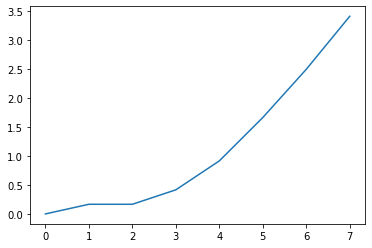

In [27]:
plt.plot(errors)

(array([4.000e+00, 1.100e+01, 2.600e+01, 1.120e+02, 6.549e+03, 1.250e+02,
        5.060e+02, 4.100e+01, 1.300e+01, 5.000e+00]),
 array([-1.993324  , -1.5586257 , -1.1239274 , -0.68922895, -0.25453058,
         0.1801678 ,  0.61486614,  1.0495645 ,  1.484263  ,  1.9189613 ,
         2.3536596 ], dtype=float32),
 <BarContainer object of 10 artists>)

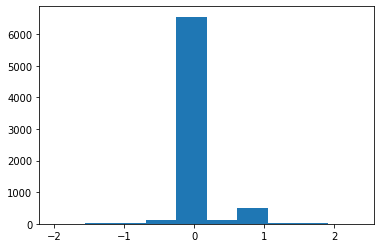

In [28]:
plt.hist([y for x in obs_models for y in x.flatten()])

In [8]:
obs_model
obs = obs_model.detach().numpy().reshape(h, w, c) > 0.5
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs)))
plt.show()

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
obs